In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams.update({'font.size': 8})

# Hello World mnist (pytorch)

支援python 版本: 3.5以上
支援pytorch版本 : 1.2以上

這次實作要使用的是深度學習界的Hello world也就是手寫數字數據集MNIST(別誤寫為MINIST歐)。MNIST 數據集來自美國國家標準與技術研究所, National Institute of St andards and Technology (NIST). 訓練集 (training set) 由來自 250 個不同人手寫的數字構成, 其中 50% 是高中學生, 50% 來自人口普查局 (the Census Bureau) 的工作人員. 測試集(test set) 也是同樣比例的手寫數字數據。基本上這個數據集毫無挑戰性，任何神經網路幾乎都能獲得很好的擬合效果，所以它也很常被做為新算法觀念驗證使用。

In [2]:
import glob
import random
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
import trident as T
from trident import *

trident 0.5.0
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.4.0.
Using pillow image backend.
Pillow version:6.2.1.


In [3]:
dataset=T.load_mnist('mnist') #讀取mnist數據集
dataset.image_transform_funcs=[normalize(127.5,127.5)] #在圖像預處理流程中加入正規化
data,label=dataset.next()
print(data.shape,label.shape)
print(dataset.signature)

img_list=[random.choice(dataset.get_all_data(is_shuffle=True)).reshape((28,28)) for i in range(10)]#從全體圖像數據(get_all_data())抽10筆
                        
merged_img=array2image(np.concatenate(img_list,axis=1)) #沿著x軸(axis=1)疊合後，利用array2image轉成圖檔


merged_img #顯示圖片

archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping class_names  in en-US   success, total 10 class names added.
(8, 28, 28) (8,)
OrderedDict([('data', (28, 28)), ('label', <class 'int'>)])


In [4]:
fdataset=T.load_mnist('fashion-mnist') #讀取fashion mnist數據集

img_list2=[random.choice(fdataset.get_all_data(is_shuffle=True)).reshape((28,28)) for i in range(10)]#從全體圖像數據(get_all_data())抽10筆               
merged_img2=array2image(np.concatenate(img_list2,axis=1)) #沿著x軸(axis=1)疊合後，利用array2image轉成圖檔

merged_img2 #顯示圖片

archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping class_names  in en-US   success, total 10 class names added.


In [5]:
#設計網路結構基礎型
net1=Sequential(
    Flatten(),
    Dense(64,use_bias=False,activation='leaky_relu'),
    Dense(32,use_bias=False,activation='leaky_relu'),
    Dense(16,use_bias=False,activation='leaky_relu'),
    Dense(2,use_bias=False,activation=None),
    Dense(10,use_bias=False,activation='softmax'))

In [6]:
#加入批次正規化
net2=Sequential(
    Flatten(),
    Dense(64,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dense(32,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dense(16,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dense(2,use_bias=False,activation=None),
    Dense(10,use_bias=False,activation='softmax'))

#加入Dropout
net3=Sequential(
    Flatten(),
    Dense(64,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dropout(0.5),
    Dense(32,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dense(16,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dense(2,use_bias=False,activation=None),
    Dense(10,use_bias=False,activation='softmax'))



In [7]:
model1=Model(input_shape=(28,28),output=net1)\
    .with_optimizer(optimizer='Ranger',lr=2e-3)\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy)

model2=Model(input_shape=(28,28),output=net2)\
    .with_optimizer(optimizer='Ranger',lr=2e-3)\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy)

model3=Model(input_shape=(28,28),output=net3)\
    .with_optimizer(optimizer='Ranger',lr=2e-3)\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy)



CrossEntropyLoss signature:[('output', [10]), ('target', [10])]
accuracy signature:[('output', [10]), ('target', [10])]
CrossEntropyLoss signature:[('output', [10]), ('target', [10])]
accuracy signature:[('output', [10]), ('target', [10])]
CrossEntropyLoss signature:[('output', [10]), ('target', [10])]
accuracy signature:[('output', [10]), ('target', [10])]


In [8]:
model1.summary()
model2.summary()
model3.summary()

--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
flatten_3                                [-1, 784]                                            0         0.0         
dense_9                                  [-1, 64]              [64, 784]                      50176     100351.0    
dense_10                                 [-1, 32]              [32, 64]                       2048      4095.0      
dense_11                                 [-1, 16]              [16, 32]                       512       1023.0      
dense_12                                 [-1, 2]               [2, 16]                        32        63.0        
dense_13                                 [-1, 10]              [10, 2]                        20        39.0        
Total params: 52,788
Trainable params: 52,788
Non-tr

In [9]:
plan=TrainingPlan()\
    .add_training_item(model1)\
    .add_training_item(model2)\
    .add_training_item(model3)\
    .with_data_loader(dataset)\
    .within_minibatch_size(128)\
    .print_progress_scheduling(200,unit='batch')\

plan.only_steps(num_steps=2500,collect_data_inteval=50,keep_weights_history=True,keep_gradient_history=True)

data_feed for model 0 :OrderedDict([('x', 'data'), ('output', 'output'), ('target', 'label')])
data_feed for model 1 :OrderedDict([('x', 'data'), ('output', 'output'), ('target', 'label')])
data_feed for model 2 :OrderedDict([('x', 'data'), ('output', 'output'), ('target', 'label')])
model 0      Step: 17s949ms | Loss: 2.302   | accuracy: 8.594%   | learning rate: 2.000e-03 | epoch: 0  ( 0/2500 )
OrderedDict([('total_losses', 2.302483081817627), ('CrossEntropyLoss', 2.302483081817627)])
model 1      Step: 53ms     | Loss: 2.306   | accuracy: 10.156%  | learning rate: 2.000e-03 | epoch: 0  ( 0/2500 )
OrderedDict([('total_losses', 2.305659294128418), ('CrossEntropyLoss', 2.305659294128418)])
model 2      Step: 45ms     | Loss: 2.303   | accuracy: 9.375%   | learning rate: 2.000e-03 | epoch: 0  ( 0/2500 )
OrderedDict([('total_losses', 2.3029465675354004), ('CrossEntropyLoss', 2.3029465675354004)])
model 0      Step: 11s192ms | Loss: 2.248   | accuracy: 18.363%  | learning rate: 2.000e-03 

True

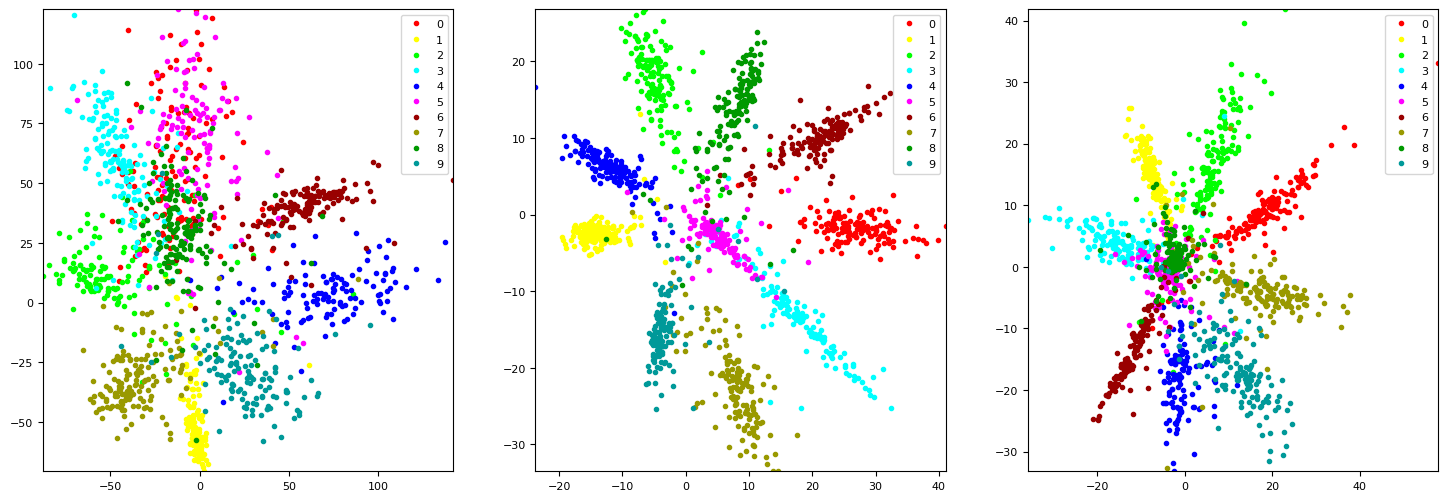

In [10]:

#plan.training_items[0].model[:4]
#plan.training_items[1].model[:11]


def centerloss_plot(plt,feat, labels,title=''):
    
    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
         '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    for i in range(10):
        plt.plot(feat[labels == i, 0], feat[labels == i, 1], '.', c=c[i])
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc = 'upper right')
    plt.xlim(xmin=feat[:,0].min(),xmax=feat[:, 0].max())
    plt.ylim(ymin=feat[:,1].min(),ymax=feat[:, 1].max())
    plt.title(title)
    
    
    
fig = plt.figure(figsize=(18,6)) 
plt.clf()
plt.ion()  # is not None:
for k in [1,2,3]:
    plt.subplot(1, 3, k)
    feats_result=[]
    label_result=[]
    fm=Sequential(plan.training_items[k-1].model[:-1])#取出指定model的從第一層到倒數第二層，將它置入於Sequentiqal中
    for i,(data,label) in enumerate(dataset):
        data=to_tensor(data)
        feats=fm(data)
        feats=to_numpy(feats)
        
        feats_result.append(feats)
        label_result.append(label)  
        if i==10:
            break

    feats_result=np.concatenate(feats_result,axis=0)
    label_result=np.concatenate(label_result,axis=0)
    plt.title('model {0}'.format(i))
    centerloss_plot(plt,feats_result,label_result)
plt.ioff() 
display.display(plt.gcf())
plt.close(fig)

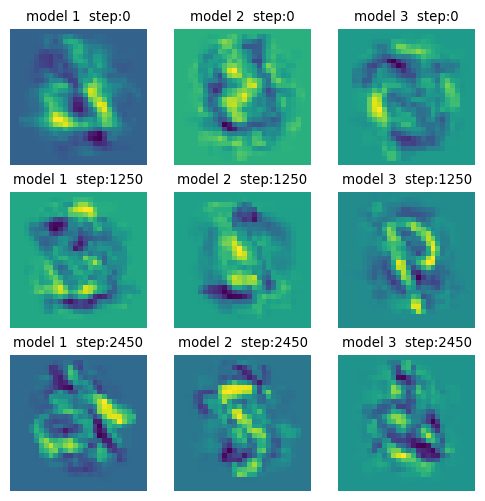

ERROR - Exception in callback functools.partial(<function Kernel.enter_eventloop.<locals>.advance_eventloop at 0x00000254412BC840>)
Traceback (most recent call last):
  File "C:\Anaconda3\envs\azuremlenv\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Anaconda3\envs\azuremlenv\lib\site-packages\ipykernel\kernelbase.py", line 310, in advance_eventloop
    eventloop(self)
  File "C:\Anaconda3\envs\azuremlenv\lib\site-packages\ipykernel\eventloops.py", line 232, in loop_tk
    app.tk.createfilehandler(stream.getsockopt(zmq.FD), READABLE, notifier)
AttributeError: '_tkinter.tkapp' object has no attribute 'createfilehandler'


In [11]:
grad_dict={}

for i in  range(3):
    grad_dict[i]=[]
    for j in range(len(plan.training_items[i].gradients_history)):
        grad_dict[i].append(to_numpy(plan.training_items[i].gradients_history[j].value_list[0].copy()).mean(0))
        
fig =plt.figure(figsize=(6,6))
plt.clf()
plt.ion()  
for j in range(3):
    for i in [1,2,3]:
        plt.subplot(3,3, 3*j+i)
        n=[0,len(grad_dict[i-1])//2,len(grad_dict[i-1])-1][j]
        grad_grid=grad_dict[i-1][n].reshape([28,28])
        plt.pcolor(grad_grid)
        plt.title('model {0}  step:{1}'.format(i,n*50))
        plt.axis("off")
plt.ioff() 
display.display(fig)
plt.close(fig)